In [1]:
# 加载画图包
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import matplotlib.patches as mp
import seaborn as sns

# 设置全局字体
font_dirs = ['/public/home/mowp/test/fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

# setting color palette
# pal = sns.color_palette("Paired")
# sns.set_palette(pal)
# sns.palplot(pal)

In [2]:
import pysam
import pandas as pd
import numpy as np
import pyranges as pr
from collections import defaultdict, Counter
from concurrent.futures import ProcessPoolExecutor
from scipy import stats
from itertools import repeat

In [3]:
# get last pa sites
# get single polya site gene

last_pa_bed = '/public/home/mowp/workspace/termination/cbRNA_pool/polya_sites/cbRNA.last_polya_cluster_summit.bed'
last_pa = pr.read_bed(last_pa_bed, as_df=True)
last_pa.columns = ['Chromosome', 'Start', 'End', 'Name', 'Score', 'Strand', 'ratio']
last_pa.loc[:, 'Chromosome'] = last_pa.loc[:, 'Chromosome'].astype('str')

mask = last_pa.loc[:, 'Name'].str.contains('_1')
single_pa_site_gene = last_pa[mask].loc[:, 'Name'].map(lambda x: x.split('_')[0])

last_pa['Name'] = last_pa['Name'].map(lambda x: x.split('_')[0])
last_pa = last_pa.set_index(['Name'])


# get gene model

gene_model_bed = '/public/home/mowp/db/Arabidopsis_thaliana/isoform/araport11.gene.bed'
gene_model = pr.read_bed(gene_model_bed, as_df=True)
gene_model = gene_model.set_index(['Name'])

In [4]:
gene_model['length'] = gene_model['End'] - gene_model['Start']

In [5]:
# get protein-coding gene

protein_coding_bed = '/public/home/mowp/db/Arabidopsis_thaliana/bed/Araport11_protein_coding.201606.bed'
protein_coding = pr.read_bed(protein_coding_bed, as_df=True)

protein_coding_gene = set(protein_coding['Name'].map(lambda x: x.split('.')[0]))

In [6]:
all_gene = set(single_pa_site_gene) & set(protein_coding_gene)

pol3_black_list = {'AT4G04565', 'AT4G04595', 'AT1G05163'}

# main function

In [7]:
STRAND_TO_BOOL = {'-': True, '+': False}
def read_through_len(infile, gene_id, method='median', debug=False):
    chrom, start, end, _, strand, _ = gene_model.loc[gene_id, :].values
    gene_strand = STRAND_TO_BOOL[strand]
    
    distance_list = []
    n = 0
    with pysam.AlignmentFile(infile, 'rb') as inbam:
        pa_site = last_pa.at[gene_id, 'End']
        
        if gene_strand:
            start = pa_site-500 if pa_site > 500 else 1
        else:
            end = pa_site+500 if pa_site+500 < inbam.get_reference_length(chrom) else inbam.get_reference_length(chrom)
        
        # for debug
        if start > end:
            print(gene_id)
            
        for read in inbam.fetch(chrom, start, end):
            polya_len = read.get_tag('pa')
            # gap = read.get_tag('ga')
            gap = 0
            read_gene_id = read.get_tag('gi')
            
            if polya_len > 15 or gap >= 5 or read_gene_id not in {gene_id, 'None'} or read.is_supplementary:
                continue
            
            if read.is_reverse is gene_strand:
                if gene_strand:
                    five_end = read.reference_end*-1
                    three_end = read.reference_start*-1
                    pa_site = last_pa.at[gene_id, 'End']*-1
                else:
                    five_end = read.reference_start
                    three_end = read.reference_end
                    pa_site = last_pa.at[gene_id, 'End']
                
                distance = three_end-pa_site  # readthrough distance
                if distance >= 50 or five_end >= pa_site:
                # if distance >= 50 and five_end <= pa_site-50:
                    distance_list.append(distance)
                    if debug:
                        print(read.query_name, distance)
    
    if len(distance_list) < 15:
        return

    if method == 'median':
        max_read_through = np.median(distance_list)
    elif method is None:
        max_read_through = max(distance_list)
    elif method == 'raw':
        return gene_id, distance_list
    else:
        raise NameError(f'{method} not found')
        
    pa_site = last_pa.at[gene_id, 'End']
    if gene_strand:
        tts = pa_site-max_read_through
    else:
        tts = pa_site+max_read_through

    return max_read_through, gene_id, chrom, pa_site, tts, strand

## cbRNA1

In [42]:
infile = '/public/home/mowp/data/ath_cbRNA/cbRNA_3/aligned_data/cb3.adjust.sorted.tagged.bam'
infile = '/public/home/mowp/test/nanopore_test/cbRNA_3/elongating_data/cbRNA_3.elongating.bam'

results = []
with ProcessPoolExecutor(max_workers=64) as e:
    for gene_id in all_gene:
        if gene_id not in pol3_black_list:
            results.append(e.submit(read_through_len, infile, gene_id, method='median'))

In [43]:
cb3_read_through_len = []
for res in results:
    result = res.result()
    if result is not None:
        cb3_read_through_len.append(result)

cb3_read_through_len = pd.DataFrame(cb3_read_through_len, columns=['length', 'gene_id', 'chrom', 'pas', 'tts', 'strand'])

In [15]:
%store cb3_read_through_len

Stored 'cb3_read_through_len' (DataFrame)


## cbRNA2

In [39]:
infile = '/public/home/mowp/data/ath_cbRNA/cbRNA_2/aligned_data/cb2.adjust.sorted.tagged.bam'
infile = '/public/home/mowp/test/nanopore_test/cbRNA_2/elongating_data/cbRNA_2.elongating.bam'
results = []
with ProcessPoolExecutor(max_workers=64) as e:
    for gene_id in all_gene:
        if gene_id not in pol3_black_list:
            results.append(e.submit(read_through_len, infile, gene_id, method='median'))

In [40]:
cb2_read_through_len = []
for res in results:
    result = res.result()
    if result is not None:
        cb2_read_through_len.append(result)

cb2_read_through_len = pd.DataFrame(cb2_read_through_len, columns=['length', 'gene_id', 'chrom', 'pas', 'tts', 'strand'])

In [11]:
%store cb2_read_through_len

Stored 'cb2_read_through_len' (DataFrame)


## nuclear RNA

In [51]:
infile = '/public/home/mowp/test/nanopore_test/20210324_col_nuclear/elongating_data/20210324_col_nuclear.elongating.bam'

results = []
with ProcessPoolExecutor(max_workers=64) as e:
    for gene_id in all_gene:
        if gene_id not in pol3_black_list:
            results.append(e.submit(read_through_len, infile, gene_id, method='median'))

In [52]:
nuclear_read_through_len = []
for res in results:
    result = res.result()
    if result is not None:
        nuclear_read_through_len.append(result)

nuclear_read_through_len = pd.DataFrame(nuclear_read_through_len, columns=['length', 'gene_id', 'chrom', 'pas', 'tts', 'strand'])

In [30]:
%store nuclear_read_through_len

Stored 'nuclear_read_through_len' (DataFrame)


## xrn3

In [48]:
infile = '/public/home/mowp/data/ath_nuclear_RNA/20210301_xrn3/elongating_data/20210301_xrn3.elongating.bam'
infile = '/public/home/mowp/test/nanopore_test/20210301_xrn3/elongating_data/20210301_xrn3.elongating.bam'
results = []
with ProcessPoolExecutor(max_workers=64) as e:
    for gene_id in all_gene:
        if gene_id not in pol3_black_list:
            results.append(e.submit(read_through_len, infile, gene_id))

In [49]:
xrn3_read_through_len = []
for res in results:
    result = res.result()
    if result is not None:
        xrn3_read_through_len.append(result)

xrn3_read_through_len = pd.DataFrame(xrn3_read_through_len, columns=['length', 'gene_id', 'chrom', 'pas', 'tts', 'strand'])

In [26]:
%store xrn3_read_through_len

Stored 'xrn3_read_through_len' (DataFrame)


## cbRNA pool

In [19]:
infile = '/public/home/mowp/workspace/termination/cbRNA_pool/elongating_data/cbRNA.elongating.bam'

results = []
with ProcessPoolExecutor(max_workers=64) as e:
    for gene_id in all_gene:
        if gene_id not in pol3_black_list:
            results.append(e.submit(read_through_len, infile, gene_id, method='median'))

In [20]:
cb_pool_read_through_len = []
for res in results:
    result = res.result()
    if result is not None:
        cb_pool_read_through_len.append(result)

cb_pool_read_through_len = pd.DataFrame(cb_pool_read_through_len, columns=['length', 'gene_id', 'chrom', 'pas', 'tts', 'strand'])

In [49]:
%store cb_pool_read_through_len

Stored 'cb_pool_read_through_len' (DataFrame)


median = 161.0
n= 9830


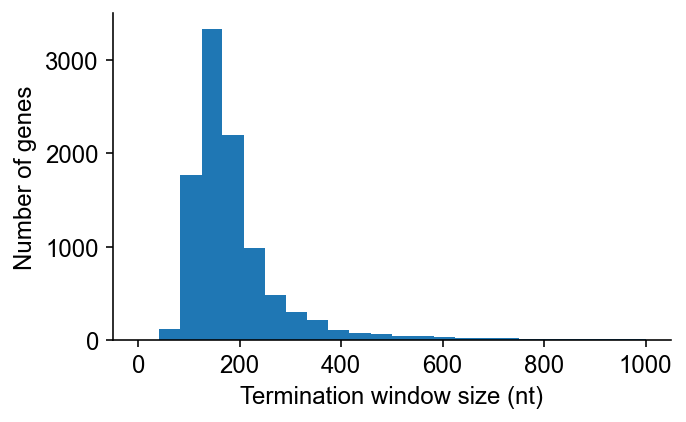

In [56]:
plt.figure(figsize=(4, 3))
bins = np.linspace(0, 1000, 25, dtype=int)
plt.hist(cb_pool_read_through_len.loc[:, 'length'], bins=bins)
plt.ylabel('Number of genes')
plt.xlabel('Termination window size (nt)')
#plt.axvline(np.median(merge_read_through_len.loc[:, 'length']), ls='--', color='k')
sns.despine(top=True, right=True)

print('median =', np.median(cb_pool_read_through_len.loc[:, 'length']))
print('n=', len(cb_pool_read_through_len.query('length <= 2000')))


# compare

## cb1 vs cb2

### median

In [52]:
data = pd.merge(cb2_read_through_len, cb3_read_through_len, on='gene_id')
data.dropna(inplace=True)

Pearson's R=0.912
n=5267


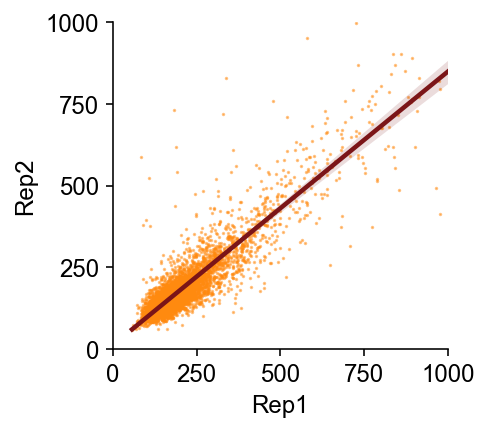

In [53]:
pearsonr = stats.pearsonr(data.loc[:, 'length_x'], data.loc[:, 'length_y'])[0]

plt.figure(figsize=(3, 3))
sns.regplot(
    x='length_y',  # cb1
    y='length_x',  # cb2
    data=data, 
    scatter_kws={'s': .5, 'color': '#FF8A0F', 'alpha': .5}, 
    line_kws={'color': '#7B1518'},
)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
# plt.title('Termination window length')
xticks = [0, 250, 500, 750, 1000]
plt.xticks(xticks)
plt.yticks(xticks)
plt.xlabel('Rep1')
plt.ylabel('Rep2')
# plt.title('Median readthrough distanace (nt)')
# plt.annotate(f'Pearson\'s R={pearsonr:.3f}', (80, 850), size='medium')
#plt.savefig('corr_read_through.svg', bbox_inches='tight')
sns.despine(top=True, right=True)
print(f'Pearson\'s R={pearsonr:.3f}')
print(f'n={len(data)}')

In [67]:
data = pd.merge(cb_pool_read_through_len, cb3_read_through_len, on='gene_id')
data.dropna(inplace=True)

Pearson's R=0.973
n=7033


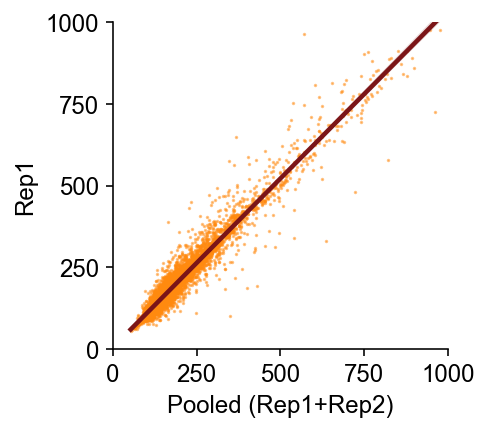

In [68]:
pearsonr = stats.pearsonr(data.loc[:, 'length_x'], data.loc[:, 'length_y'])[0]

plt.figure(figsize=(3, 3))
sns.regplot(
    x='length_x',  # cb1
    y='length_y',  # cb2
    data=data, 
    scatter_kws={'s': .5, 'color': '#FF8A0F', 'alpha': .5}, 
    line_kws={'color': '#7B1518'},
)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
# plt.title('Termination window length')
xticks = [0, 250, 500, 750, 1000]
plt.xticks(xticks)
plt.yticks(xticks)
plt.xlabel('Pooled (Rep1+Rep2)')
plt.ylabel('Rep1')
# plt.title('Median readthrough distanace (nt)')
# plt.annotate(f'Pearson\'s R={pearsonr:.3f}', (80, 850), size='medium')
#plt.savefig('corr_read_through.svg', bbox_inches='tight')
sns.despine(top=True, right=True)
print(f'Pearson\'s R={pearsonr:.3f}')
print(f'n={len(data)}')

In [69]:
data = pd.merge(cb_pool_read_through_len, cb2_read_through_len, on='gene_id')
data.dropna(inplace=True)

Pearson's R=0.967
n=5921


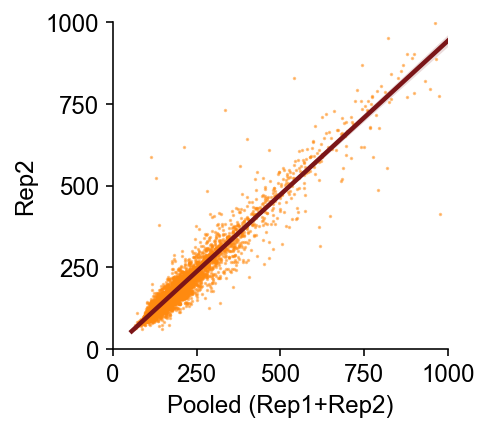

In [70]:
pearsonr = stats.pearsonr(data.loc[:, 'length_x'], data.loc[:, 'length_y'])[0]

plt.figure(figsize=(3, 3))
sns.regplot(
    x='length_x',  # cb1
    y='length_y',  # cb2
    data=data, 
    scatter_kws={'s': .5, 'color': '#FF8A0F', 'alpha': .5}, 
    line_kws={'color': '#7B1518'},
)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
# plt.title('Termination window length')
xticks = [0, 250, 500, 750, 1000]
plt.xticks(xticks)
plt.yticks(xticks)
plt.xlabel('Pooled (Rep1+Rep2)')
plt.ylabel('Rep2')
# plt.title('Median readthrough distanace (nt)')
# plt.annotate(f'Pearson\'s R={pearsonr:.3f}', (80, 850), size='medium')
#plt.savefig('corr_read_through.svg', bbox_inches='tight')
sns.despine(top=True, right=True)
print(f'Pearson\'s R={pearsonr:.3f}')
print(f'n={len(data)}')

### longest

In [71]:
infile = '/public/home/mowp/test/nanopore_test/cbRNA_2/elongating_data/cbRNA_2.elongating.bam'
results = []
with ProcessPoolExecutor(max_workers=64) as e:
    for gene_id in all_gene:
        if gene_id not in pol3_black_list:
            results.append(e.submit(read_through_len, infile, gene_id, method=None))

In [72]:
cb2_max_len = []
for res in results:
    result = res.result()
    if result is not None:
        cb2_max_len.append(result)

cb2_max_len = pd.DataFrame(cb2_max_len, columns=['length', 'gene_id', 'chrom', 'pas', 'tts', 'strand'])

In [73]:
infile = '/public/home/mowp/test/nanopore_test/cbRNA_3/elongating_data/cbRNA_3.elongating.bam'
results = []
with ProcessPoolExecutor(max_workers=64) as e:
    for gene_id in all_gene:
        if gene_id not in pol3_black_list:
            results.append(e.submit(read_through_len, infile, gene_id, method=None))

In [74]:
cb3_max_len = []
for res in results:
    result = res.result()
    if result is not None:
        cb3_max_len.append(result)

cb3_max_len = pd.DataFrame(cb3_max_len, columns=['length', 'gene_id', 'chrom', 'pas', 'tts', 'strand'])

In [75]:
infile = '/public/home/mowp/workspace/termination/cbRNA_pool/elongating_data/cbRNA.elongating.bam'
results = []
with ProcessPoolExecutor(max_workers=64) as e:
    for gene_id in all_gene:
        if gene_id not in pol3_black_list:
            results.append(e.submit(read_through_len, infile, gene_id, method=None))

In [76]:
cb_max_len = []
for res in results:
    result = res.result()
    if result is not None:
        cb_max_len.append(result)

cb_max_len = pd.DataFrame(cb_max_len, columns=['length', 'gene_id', 'chrom', 'pas', 'tts', 'strand'])

In [56]:
data = pd.merge(cb2_max_len, cb3_max_len, on='gene_id')
data.dropna(inplace=True)

Pearson's R=0.591
n=5267


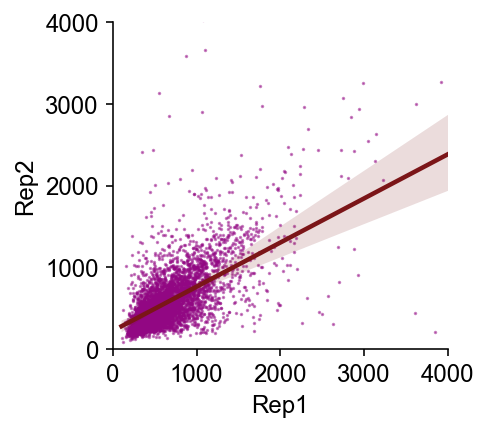

In [58]:
pearsonr = stats.pearsonr(data.loc[:, 'length_x'], data.loc[:, 'length_y'])[0]

plt.figure(figsize=(3, 3))
sns.regplot(
    x='length_y',  # cb1
    y='length_x',  # cb2
    data=data, 
    scatter_kws={'s': .5, 'color': '#920783', 'alpha': .5}, 
    line_kws={'color': '#7B1518'},
)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 4000)
plt.ylim(0, 4000)
# plt.title('Termination window length')
# xticks = [0, 250, 500, 750, 1000]
# plt.xticks(xticks)
# plt.yticks(xticks)
plt.xlabel('Rep1')
plt.ylabel('Rep2')
# plt.title('Longest readthrough distance (nt)')
# plt.annotate(f'Pearson\'s R={pearsonr:.3f}', (80, 850), size='medium')
#plt.savefig('corr_read_through.svg', bbox_inches='tight')
sns.despine(top=True, right=True)
print(f'Pearson\'s R={pearsonr:.3f}')
print(f'n={len(data)}')

In [78]:
data = pd.merge(cb_max_len, cb3_max_len, on='gene_id')
data.dropna(inplace=True)

Pearson's R=0.916
n=7033


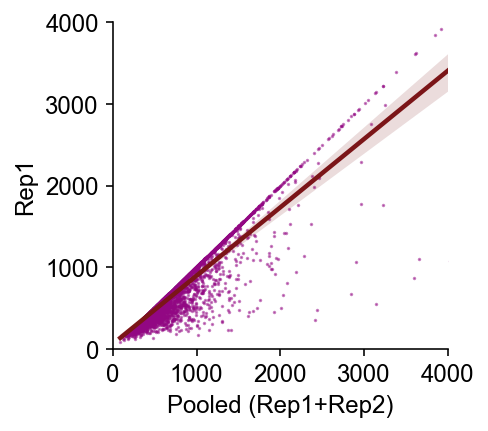

In [79]:
pearsonr = stats.pearsonr(data.loc[:, 'length_x'], data.loc[:, 'length_y'])[0]

plt.figure(figsize=(3, 3))
sns.regplot(
    x='length_x',  # cb1
    y='length_y',  # cb2
    data=data, 
    scatter_kws={'s': .5, 'color': '#920783', 'alpha': .5}, 
    line_kws={'color': '#7B1518'},
)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 4000)
plt.ylim(0, 4000)
# plt.title('Termination window length')
# xticks = [0, 250, 500, 750, 1000]
# plt.xticks(xticks)
# plt.yticks(xticks)
plt.xlabel('Pooled (Rep1+Rep2)')
plt.ylabel('Rep1')
# plt.title('Longest readthrough distance (nt)')
# plt.annotate(f'Pearson\'s R={pearsonr:.3f}', (80, 850), size='medium')
#plt.savefig('corr_read_through.svg', bbox_inches='tight')
sns.despine(top=True, right=True)
print(f'Pearson\'s R={pearsonr:.3f}')
print(f'n={len(data)}')

In [81]:
data = pd.merge(cb_max_len, cb2_max_len, on='gene_id')
data.dropna(inplace=True)

Pearson's R=0.811
n=5921


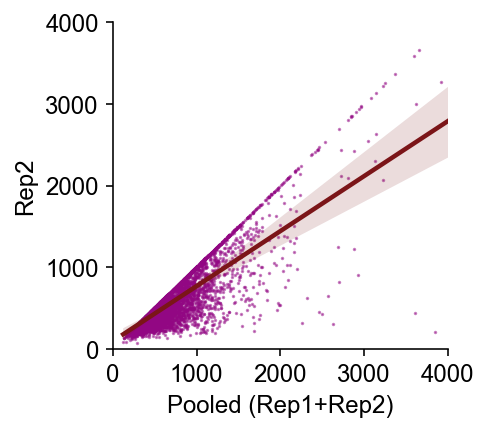

In [84]:
pearsonr = stats.pearsonr(data.loc[:, 'length_x'], data.loc[:, 'length_y'])[0]

plt.figure(figsize=(3, 3))
sns.regplot(
    x='length_x',  # cb1
    y='length_y',  # cb2
    data=data, 
    scatter_kws={'s': .5, 'color': '#920783', 'alpha': .5}, 
    line_kws={'color': '#7B1518'},
)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 4000)
plt.ylim(0, 4000)
# plt.title('Termination window length')
# xticks = [0, 250, 500, 750, 1000]
# plt.xticks(xticks)
# plt.yticks(xticks)
plt.xlabel('Pooled (Rep1+Rep2)')
plt.ylabel('Rep2')
# plt.title('Longest readthrough distance (nt)')
# plt.annotate(f'Pearson\'s R={pearsonr:.3f}', (80, 850), size='medium')
#plt.savefig('corr_read_through.svg', bbox_inches='tight')
sns.despine(top=True, right=True)
print(f'Pearson\'s R={pearsonr:.3f}')
print(f'n={len(data)}')

## cbRNA vs nuclear RNA

### nuclear RNA vs cb1

In [72]:
data = pd.merge(nuclear_read_through_len, cb3_read_through_len, on='gene_id')
data.dropna(inplace=True)

Pearson's R=0.880
n=5208


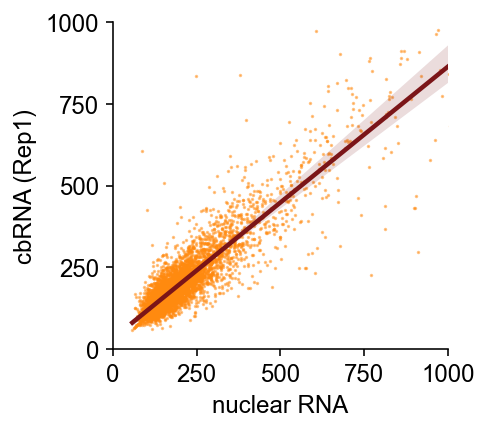

In [73]:
pearsonr = stats.pearsonr(data.loc[:, 'length_x'], data.loc[:, 'length_y'])[0]

plt.figure(figsize=(3, 3))
sns.regplot(
    x='length_x',
    y='length_y',
    data=data, 
    scatter_kws={'s': .5, 'color': '#FF8A0F', 'alpha': .5}, 
    line_kws={'color': '#7B1518'},
)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
# plt.title('Termination window length')
xticks = [0, 250, 500, 750, 1000]
plt.xticks(xticks)
plt.yticks(xticks)
plt.ylabel('cbRNA (Rep1)')
plt.xlabel('nuclear RNA')
# plt.title('Median readthrough distanace (nt)')
# plt.annotate(f'Pearson\'s R={pearsonr:.3f}', (80, 850), size='medium')
#plt.savefig('corr_read_through.svg', bbox_inches='tight')
sns.despine(top=True, right=True)
print(f'Pearson\'s R={pearsonr:.3f}')
print(f'n={len(data)}')

### nuclear RNA vs cb2

In [77]:
data = pd.merge(nuclear_read_through_len, cb2_read_through_len, on='gene_id')
data.dropna(inplace=True)

Pearson's R=0.854
n=4624


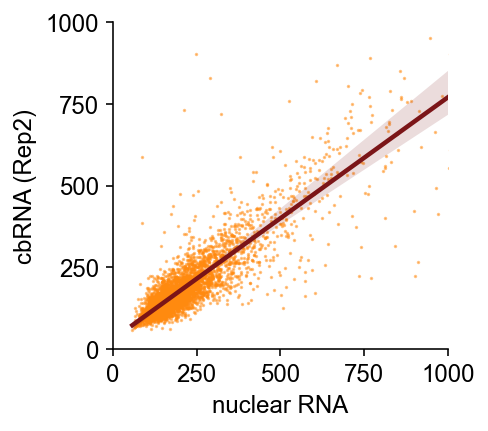

In [78]:
pearsonr = stats.pearsonr(data.loc[:, 'length_x'], data.loc[:, 'length_y'])[0]

plt.figure(figsize=(3, 3))
sns.regplot(
    x='length_x',
    y='length_y',
    data=data, 
    scatter_kws={'s': .5, 'color': '#FF8A0F', 'alpha': .5}, 
    line_kws={'color': '#7B1518'},
)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
# plt.title('Termination window length')
xticks = [0, 250, 500, 750, 1000]
plt.xticks(xticks)
plt.yticks(xticks)
plt.ylabel('cbRNA (Rep2)')
plt.xlabel('nuclear RNA')
# plt.title('Median readthrough distanace (nt)')
# plt.annotate(f'Pearson\'s R={pearsonr:.3f}', (80, 850), size='medium')
#plt.savefig('corr_read_through.svg', bbox_inches='tight')
sns.despine(top=True, right=True)
print(f'Pearson\'s R={pearsonr:.3f}')
print(f'n={len(data)}')